In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm # For progress bars
import torch.nn.functional as F

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Configuration ---
KAGGLE_DATA_ROOT = '/kaggle/input/face-recognition5'
TRAIN_DIR = os.path.join(KAGGLE_DATA_ROOT, 'classification_data', 'train_data')
VAL_DIR = os.path.join(KAGGLE_DATA_ROOT, 'classification_data', 'val_data')
VERIF_PAIRS_VAL = os.path.join(KAGGLE_DATA_ROOT, 'verification_pairs_val.txt')
MODEL_SAVE_PATH = '/kaggle/working/face_classifier.pth'

# --- Hyperparameters ---
IMAGE_SIZE = (224, 224) # ResNet-18 expects 224x224
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10 # Start with 10, may need more

# --- Get Class Count ---
# We need to know how many people (classes) we are classifying
# We can get this from the data exploration notebook, or run this:
try:
    class_names = sorted(os.listdir(TRAIN_DIR))
    NUM_CLASSES = len(class_names)
    print(f"Found {NUM_CLASSES} classes (people) in {TRAIN_DIR}")
except FileNotFoundError:
    print("Error: Training directory not found. Check paths.")
    NUM_CLASSES = -1 # Set to -1 to show error

Found 4000 classes (people) in /kaggle/input/face-recognition5/classification_data/train_data


In [3]:
# Define transformations
# Using standard ImageNet mean/std for pre-trained model
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create ImageFolder datasets
try:
    image_datasets = {
        'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
        'val': datasets.ImageFolder(VAL_DIR, data_transforms['val'])
    }
    
    # Create DataLoaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    print(f"Training images: {dataset_sizes['train']}, Validation images: {dataset_sizes['val']}")
    
except Exception as e:
    print(f"Error loading data: {e}. Check paths and data integrity.")

Training images: 380638, Validation images: 8000


In [4]:
def get_model(num_classes):
    """
    Loads a pre-trained ResNet-18 and replaces the final
    fully connected layer for our classification task.
    """
    # Load a pre-trained ResNet-18
    model = models.resnet18(pretrained=True)
    
    # Get the number of input features for the final layer
    num_ftrs = model.fc.in_features
    
    # Replace the final layer
    # model.fc will be our "embedding" layer
    # We add a new final layer for classification
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

if NUM_CLASSES > 0:
    model = get_model(NUM_CLASSES).to(device)
    print("Model loaded and final layer replaced.")
    # print(model) # Uncomment to see model structure
else:
    print("Cannot create model. NUM_CLASSES is not set.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Model loaded and final layer replaced.


In [5]:
# --- Set up Loss and Optimizer ---
if 'model' in locals():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    print("Model not defined, skipping training setup.")

# --- Training and Validation Function ---
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Use tqdm for a progress bar
            batch_iterator = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}/{num_epochs}")
            
            # Iterate over data
            for inputs, labels in batch_iterator:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                batch_iterator.set_postfix(loss=loss.item(), acc=torch.sum(preds == labels.data).item() / inputs.size(0))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete!')
    return model

In [6]:
if 'model' in locals():
    # Train the model
    model = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)
    
    # Save the model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
else:
    print("Skipping training.")

Epoch 1/10
----------


train Epoch 1/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 7.8460 Acc: 0.0024


val Epoch 1/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 6.9052 Acc: 0.0084
Epoch 2/10
----------


train Epoch 2/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 4.9594 Acc: 0.1281


val Epoch 2/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 4.0568 Acc: 0.2235
Epoch 3/10
----------


train Epoch 3/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 3.0142 Acc: 0.3820


val Epoch 3/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 2.7450 Acc: 0.4348
Epoch 4/10
----------


train Epoch 4/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 2.0741 Acc: 0.5530


val Epoch 4/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 2.1411 Acc: 0.5484
Epoch 5/10
----------


train Epoch 5/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 1.5625 Acc: 0.6528


val Epoch 5/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.8715 Acc: 0.6046
Epoch 6/10
----------


train Epoch 6/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 1.2578 Acc: 0.7147


val Epoch 6/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.6385 Acc: 0.6554
Epoch 7/10
----------


train Epoch 7/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 1.0493 Acc: 0.7565


val Epoch 7/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.4912 Acc: 0.6881
Epoch 8/10
----------


train Epoch 8/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 0.8943 Acc: 0.7884


val Epoch 8/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.4671 Acc: 0.6961
Epoch 9/10
----------


train Epoch 9/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 0.7695 Acc: 0.8141


val Epoch 9/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.3198 Acc: 0.7175
Epoch 10/10
----------


train Epoch 10/10:   0%|          | 0/5948 [00:00<?, ?it/s]

train Loss: 0.6714 Acc: 0.8343


val Epoch 10/10:   0%|          | 0/125 [00:00<?, ?it/s]

val Loss: 1.2948 Acc: 0.7329
Training complete!
Model saved to /kaggle/working/face_classifier.pth


In [7]:
if NUM_CLASSES > 0:
    # 1. Load the full classifier model structure
    embedding_model = get_model(NUM_CLASSES)
    
    # 2. Load the saved weights
    try:
        embedding_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Trained weights loaded successfully.")
    except FileNotFoundError:
        print("ERROR: Model file not found. Did the training step run?")
    
    # 3. Modify the model to output embeddings
    # We remove the final layer ('fc')
    # The new final layer will be the one *before* 'fc', which is 'avgpool'
    # We can get its output using a "hook" or by redefining the model
    
    # Easiest way: create a new model that is identical up to the avgpool layer
    modules = list(embedding_model.children())[:-1] # Remove the last layer (fc)
    embedding_model = nn.Sequential(*modules)
    embedding_model = embedding_model.to(device)
    embedding_model.eval() # Set to evaluation mode
    
    print("Embedding model created.")
    
    # Test with a dummy input
    dummy_input = torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
    output = embedding_model(dummy_input)
    print(f"Embedding vector shape: {output.shape}") # Should be [1, 512, 1, 1] for ResNet-18
    
else:
    print("Cannot create embedding model. NUM_CLASSES is not set.")

Trained weights loaded successfully.
Embedding model created.
Embedding vector shape: torch.Size([1, 512, 1, 1])


In [11]:
# We need a transform for single images
# Note: This is the *validation* transform
val_transform = data_transforms['val']

def get_embedding(image_path, model, transform):
    """
    Given an image path, load it, transform it,
    and return its embedding vector.
    """
    try:
        # 1. Load image
        img = Image.open(image_path).convert('RGB')
        
        # 2. Apply transform
        img_t = transform(img)
        
        # 3. Add batch dimension (C, H, W) -> (1, C, H, W)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        
        # 4. Get embedding
        with torch.no_grad(): # No need to track gradients
            embedding = model(batch_t)
        
        # 5. Flatten the embedding
        # Output shape is [1, 512, 1, 1], flatten to [512]
        embedding_flat = torch.flatten(embedding).cpu().numpy()
        
        return embedding_flat
        
    except FileNotFoundError:
        print(f"Warning: File not found {image_path}. Skipping.")
        return None

In [12]:
print("Loading verification pairs...")
try:
    pairs_df = pd.read_csv(VERIF_PAIRS_VAL, sep=' ', header=None, names=['img1', 'img2', 'label'])
    
    # IMPORTANT: Prepend the root directory to image paths
    pairs_df['img1'] = KAGGLE_DATA_ROOT + '/' + pairs_df['img1']
    pairs_df['img2'] = KAGGLE_DATA_ROOT + '/' + pairs_df['img2']
    
    print(f"Loaded {len(pairs_df)} verification pairs.")
    print(pairs_df.head())

    print("\nGenerating embeddings for all pairs...")
    embeddings1 = []
    embeddings2 = []
    valid_labels = [] # To store labels for pairs where both images were found
    
    for index, row in tqdm(pairs_df.iterrows(), total=pairs_df.shape[0]):
        emb1 = get_embedding(row['img1'], embedding_model, val_transform)
        emb2 = get_embedding(row['img2'], embedding_model, val_transform)
        
        # Only add if both embeddings were generated successfully
        if emb1 is not None and emb2 is not None:
            embeddings1.append(emb1)
            embeddings2.append(emb2)
            valid_labels.append(row['label'])
    
    embeddings1 = np.array(embeddings1)
    embeddings2 = np.array(embeddings2)
    valid_labels = np.array(valid_labels)
    
    print(f"Generated embeddings for {len(valid_labels)} valid pairs.")
    
except FileNotFoundError:
    print(f"Error: Could not find {VERIF_PAIRS_VAL}. Check path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading verification pairs...
Loaded 8805 verification pairs.
                                                img1  \
0  /kaggle/input/face-recognition5/verification_d...   
1  /kaggle/input/face-recognition5/verification_d...   
2  /kaggle/input/face-recognition5/verification_d...   
3  /kaggle/input/face-recognition5/verification_d...   
4  /kaggle/input/face-recognition5/verification_d...   

                                                img2  label  
0  /kaggle/input/face-recognition5/verification_d...      0  
1  /kaggle/input/face-recognition5/verification_d...      1  
2  /kaggle/input/face-recognition5/verification_d...      0  
3  /kaggle/input/face-recognition5/verification_d...      1  
4  /kaggle/input/face-recognition5/verification_d...      0  

Generating embeddings for all pairs...


  0%|          | 0/8805 [00:00<?, ?it/s]

Generated embeddings for 8805 valid pairs.



--- Evaluation Results ---
AUC (Cosine Similarity): 0.8947
AUC (Euclidean Distance): 0.8947


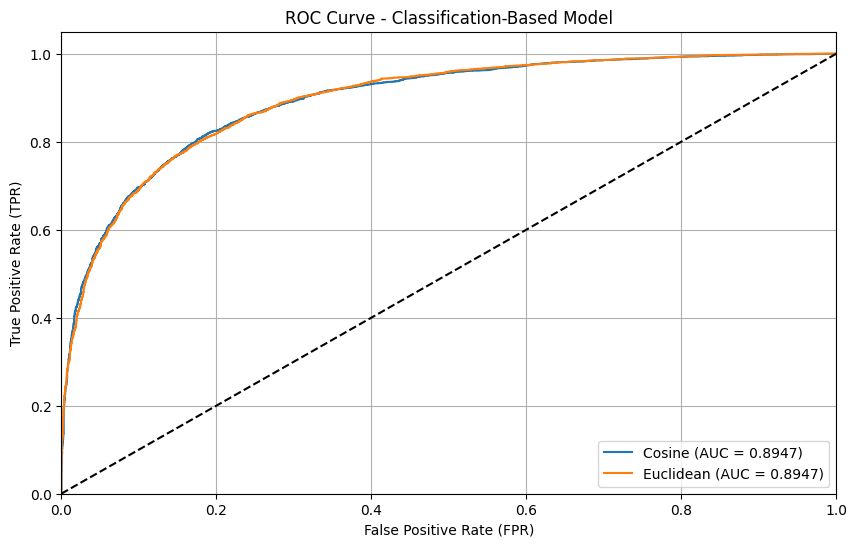

In [13]:
if 'embeddings1' in locals() and len(embeddings1) > 0:
    # --- 1. Calculate Cosine Similarity ---
    # [cite: 69]
    # F.cosine_similarity expects (N, D) tensors
    emb1_t = torch.from_numpy(embeddings1)
    emb2_t = torch.from_numpy(embeddings2)
    cosine_scores = F.cosine_similarity(emb1_t, emb2_t).numpy()
    
    # --- 2. Calculate Euclidean Distance ---
    # [cite: 69]
    # We will use the *negative* distance as a score,
    # since ROC/AUC expects higher scores for positive pairs.
    diff = embeddings1 - embeddings2
    euclidean_dist = np.sqrt(np.sum(np.square(diff), axis=1))
    euclidean_scores = -euclidean_dist # Higher score = more similar (less distance)
    
    # Get true labels [cite: 95]
    true_labels = valid_labels
    
    # --- 3. Calculate ROC/AUC for both metrics [cite: 62] ---
    fpr_cos, tpr_cos, thresholds_cos = roc_curve(true_labels, cosine_scores)
    auc_cos = auc(fpr_cos, tpr_cos)
    
    fpr_euc, tpr_euc, thresholds_euc = roc_curve(true_labels, euclidean_scores)
    auc_euc = auc(fpr_euc, tpr_euc)
    
    print(f"\n--- Evaluation Results ---")
    print(f"AUC (Cosine Similarity): {auc_cos:.4f}")
    print(f"AUC (Euclidean Distance): {auc_euc:.4f}")
    
    # --- 4. Plot ROC Curve [cite: 64] ---
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_cos, tpr_cos, label=f'Cosine (AUC = {auc_cos:.4f})')
    plt.plot(fpr_euc, tpr_euc, label=f'Euclidean (AUC = {auc_euc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve - Classification-Based Model')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
else:
    print("Skipping evaluation, embeddings not generated.")